# Описание проекта

**Проект "Сборный проект 2"** 

Компания - стартап по продаже продуктов питания.

Задачи: 

1. Проанализировать воронку продаж и определить шаги, на которых у пользователей возникают какие-то сложности
2. Провести анализ результатов А/В-тестирования использования новых шрифтов в приложении

# Подготовка

## Импорт библиотек и чтение данных

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from plotly import graph_objects as go
import math as mth
import seaborn as sns
from io import BytesIO
import requests
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import warnings
warnings.simplefilter('ignore') 


import psutil
import plotly.io as pio
pio.renderers.default='notebook'

from IPython.display import Image

In [2]:
spreadsheet_id = '1oZ2EFULzlsvh3777kya0G3Vbwapu2SYlJa1DKggm3Go'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
data = pd.read_csv(BytesIO(r.content))

## Предобработка данных

### Проверка данных

In [3]:
#посмотрим на данные
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


1. Пропуски в данных отсутствуют
2. В датасете только 1 столбец с не номинативными переменными (над которыми мы можем проводить арифметические операции для достижения какого-либо осмысленного результата) - это столбец `EventTimestamp`
3. Судя по значениям в столбце `EventTimestamp`, дата в данном случае записана в формате UNIX-времени, то есть количества секунд с 1 января 1970 года - для корректного анализа потребуется преобразование в "классический" формат, удобный для считывания человеком

In [5]:
#поменяем дату в столбце лямбда-функцией, в которой применим метод извлечения из unix time модуля datetime
data['EventTimestamp'] = data['EventTimestamp'].apply(lambda x: datetime.fromtimestamp(x))

In [6]:
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,2019-07-25 07:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 14:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 14:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 14:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 14:48:42,248


In [7]:
#после преобразования оценим значения в столбце с датами
data['EventTimestamp'].describe()

count                  244126
unique                 176654
top       2019-08-01 17:40:35
freq                        9
first     2019-07-25 07:43:36
last      2019-08-08 00:15:17
Name: EventTimestamp, dtype: object

Мы видим, что даты лежат в пределах периода, равного одному месяцу (30 дней). Другими словами, некорректных дат в датасете нет.

Также имеет смысл оценить, что содержится в столбце `EventName` на предмет некорректных значений, хотя это маловероятно, учитывая явно "машиногенерируемый" характер данных. 

In [8]:
data['EventName'].value_counts()

MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: EventName, dtype: int64

In [9]:
data['ExpId'].value_counts()

248    85747
246    80304
247    78075
Name: ExpId, dtype: int64

In [10]:
#поменяем наименования столбцов для более простого восприятия

data = data.rename(columns={
    'EventName': 'event',
    'DeviceIDHash': 'id',
    'EventTimestamp': 'timestamp',
    'ExpId': 'test_group'})

data.head()

,event,id,timestamp,test_group
0,MainScreenAppear,4575588528974610257,2019-07-25 07:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 14:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 14:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 14:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 14:48:42,248


In [11]:
#Проверим данные на наличие полных дубликатов 
print('Количество полных дубликатов в данных:', sum(data.duplicated()))

Количество полных дубликатов в данных: 413


In [12]:
#так как в данных есть дубликаты, мы применим к дата-сету методу drop_duplicates
data = data.drop_duplicates().reset_index(drop=True)

In [13]:
len(data)

243713

Проблем нет. Таким образом, мы имеем: 

1. Таблицу из 4 столбцов, содержащую 244126 наблюдений (243713 после удаления дубликатов)
2. В данных отсутствуют пропуски 
3. Потребовалось только преобразование даты из UNIX-формата в человекочитаемый вариант
4. Ошибочных дат, типов событий или идентификаторов групп в данных также не наблюдается
5. В таблице обнаружено 413 полных дубликатов строк 

# Анализ данных

## Изучение данных

In [14]:
#добавим в датасет столбцы с датой и временем по отдельности для более простого последующего анализа воронки
data['date'] = pd.to_datetime(data['timestamp'].dt.date)
data['time'] = data['timestamp'].dt.time

In [15]:
data.head()

,event,id,timestamp,test_group,date,time
0,MainScreenAppear,4575588528974610257,2019-07-25 07:43:36,246,2019-07-25,07:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 14:11:42,246,2019-07-25,14:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 14:28:47,248,2019-07-25,14:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 14:28:47,248,2019-07-25,14:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 14:48:42,248,2019-07-25,14:48:42


In [16]:
print('Количество уникальных событий в датасете:', len(data['event'].unique()))
print('Количество уникальных пользователей в датасете:', len(data['id'].unique()))

Количество уникальных событий в датасете: 5
Количество уникальных пользователей в датасете: 7551


In [17]:
print('Среднее количество событий на пользователя:', data.groupby(
    'id', as_index=False
).agg({'date': 'count'})['date'].mean().round(2))

Среднее количество событий на пользователя: 32.28


In [18]:
print('Самая ранняя дата в датасете:', data['timestamp'].min())
print('Самая поздняя дата в датасете:', data['timestamp'].max())
print(
    'Длина периода наблюдений:',
    int((data['timestamp'].max() - data['timestamp'].min())/np.timedelta64(1, 'D')),
    'дней'
)

Самая ранняя дата в датасете: 2019-07-25 07:43:36
Самая поздняя дата в датасете: 2019-08-08 00:15:17
Длина периода наблюдений: 13 дней


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event       243713 non-null  object        
 1   id          243713 non-null  int64         
 2   timestamp   243713 non-null  datetime64[ns]
 3   test_group  243713 non-null  int64         
 4   date        243713 non-null  datetime64[ns]
 5   time        243713 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 11.2+ MB


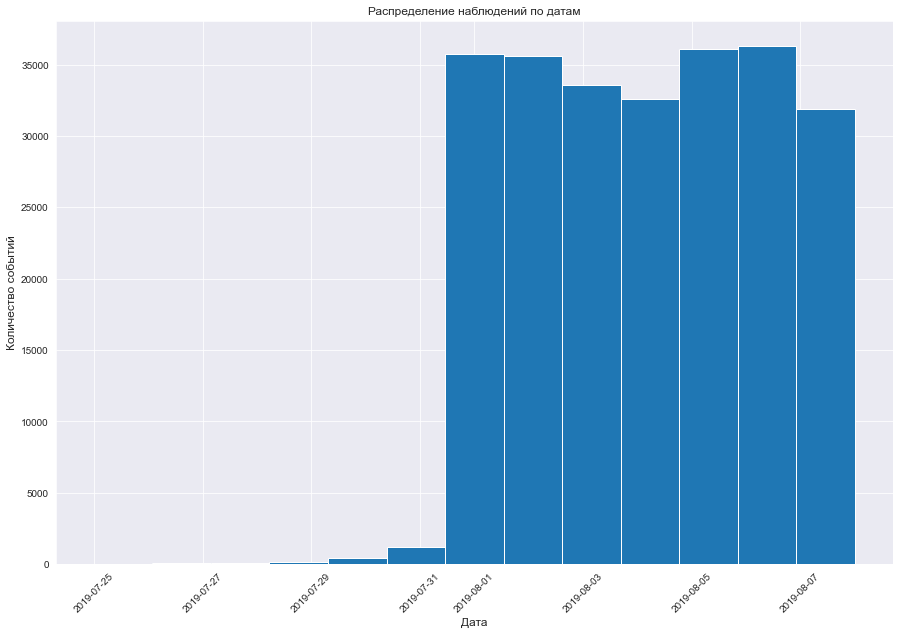

In [20]:
x = data['date']
sns.set_style('darkgrid')

fig, ax = plt.subplots(figsize=(15, 10))
plt.grid(axis='both')
plt.xticks(rotation=45)
plt.title('Распределение наблюдений по датам')
plt.grid(axis='both')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество событий', fontsize=12)

ax.hist(x,
        bins=13
       )

plt.show()

In [21]:
data.head(5)

,event,id,timestamp,test_group,date,time
0,MainScreenAppear,4575588528974610257,2019-07-25 07:43:36,246,2019-07-25,07:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 14:11:42,246,2019-07-25,14:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 14:28:47,248,2019-07-25,14:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 14:28:47,248,2019-07-25,14:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 14:48:42,248,2019-07-25,14:48:42


На гистограмме мы можем наблюдать интересное явление:

1. До 31 июля частота значение близка к нулевой относительно данных за последующие дни
2. 31 июля количество наблюдений выше в 4-5 раз относительно предыдущей даты, но все еще гораздо меньше того, что мы наблюдаем в данных, начиная с 1 августа (около 200 наблюдений против порядка 3.5-3.6 тысяч)

Вероятно, в данных есть некие "остаточные" значения, которые могут исказить результаты последующего анализа воронки и результатов А/В теста. 

Для корректной обработки данных мы: 

1. Отсортируем записи в таблице по возрастанию даты и времени наблюдения - даже если это было сделано ранее, мы все равно произведем операцию для уверенности в результате 
2. Получим самое раннее время для самого первого типа событий в разрезе пользователей
3. На основе этой информации откинем из исходного датасета те события, тип которых отличен от самого первого в цепочке при более ранней дате фиксации

Мы располагаем пятью видами событий:

- MainScreenAppear - вероятно, появление главного экрана приложения           
- OffersScreenAppear - вероятно, появление экрана с предложениями (предположительно, пользователи переходили к экрану просмотра товаров)          
- CartScreenAppear - вероятно, появление корзины на экране            
- PaymentScreenSuccessful - вероятно, появление окна успешной оплаты товаров в корзине     
- Tutorial - руководство пользователя (обучение)

Судя по количеству наблюдений с различными типами событий, воронка движентся сверху вниз от события MainScreenAppear до PaymentScreenSuccessful. Исключение - Tutorial. Скорее всего, этот экран появляется сразу же после открытия главного экрана приложения и предлагает пройти краткое знакомство с интерфейсом приложения, но не все пользователи соглашаются на это обучение, поэтому цифры появления экрана туториала невелики

In [22]:
data['event'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event, dtype: int64

In [23]:
data = data.sort_values(by='timestamp')
data.head()

,event,id,timestamp,test_group,date,time
0,MainScreenAppear,4575588528974610257,2019-07-25 07:43:36,246,2019-07-25,07:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 14:11:42,246,2019-07-25,14:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 14:28:47,248,2019-07-25,14:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 14:28:47,248,2019-07-25,14:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 14:48:42,248,2019-07-25,14:48:42


In [24]:
#исходя из утверждения о том, что событие MainScreenAppear - первое в цепочке, мы сформируем датафрейм
#куда запишем минимальное значение штампа времени для такого события
first_main_screen_occassion = data[
    data['event'] == 'MainScreenAppear'].groupby('id', as_index=False).agg({'timestamp': 'min'}
                                                                          ).sort_values(by='timestamp')
first_main_screen_occassion.columns=['id', 'first_main_screen']
first_main_screen_occassion.head()

,id,first_main_screen
3613,4575588528974610257,2019-07-25 07:43:36
5934,7416695313311560658,2019-07-25 14:11:42
4519,5682100281902512875,2019-07-25 23:14:37
1438,1850981295691852772,2019-07-25 23:31:42
4289,5407636962369102641,2019-07-26 06:35:12


In [25]:
#присоединим значения минимального штампа для события MainScreenAppear
data = data.merge(first_main_screen_occassion, on='id', how='left')
data.head()

,event,id,timestamp,test_group,date,time,first_main_screen
0,MainScreenAppear,4575588528974610257,2019-07-25 07:43:36,246,2019-07-25,07:43:36,2019-07-25 07:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 14:11:42,246,2019-07-25,14:11:42,2019-07-25 14:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 14:28:47,248,2019-07-25,14:28:47,2019-08-01 13:03:22
3,CartScreenAppear,3518123091307005509,2019-07-25 14:28:47,248,2019-07-25,14:28:47,2019-08-01 13:03:22
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 14:48:42,248,2019-07-25,14:48:42,2019-08-01 05:14:29


Можем наблюдать даже в первых 5 строках события, зафиксированные раньше, чем событие `MainScreenAppear`. Так как мы хотим получить достоверные данные, мы сделаев отсев таких значений из датафрейма. 

In [26]:
#отберем только те строки, дата фиксации события в которых меньше или равна дате первого в сете события MainScreenAppear
data = data[data['timestamp'] >= data['first_main_screen']]
data.head()

,event,id,timestamp,test_group,date,time,first_main_screen
0,MainScreenAppear,4575588528974610257,2019-07-25 07:43:36,246,2019-07-25,07:43:36,2019-07-25 07:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 14:11:42,246,2019-07-25,14:11:42,2019-07-25 14:11:42
7,MainScreenAppear,5682100281902512875,2019-07-25 23:14:37,246,2019-07-25,23:14:37,2019-07-25 23:14:37
8,MainScreenAppear,1850981295691852772,2019-07-25 23:31:42,247,2019-07-25,23:31:42,2019-07-25 23:31:42
9,MainScreenAppear,5407636962369102641,2019-07-26 06:35:12,246,2019-07-26,06:35:12,2019-07-26 06:35:12


In [27]:
print('Удалено {:.0f} "лишних" событий'.format(244126-len(data)))
print('Выборка сократилась на {:.2f}%'.format((1-(len(data)/244126))*100))
print('Удалено {:.0f} "лишних" пользователей,'.format(7551-len(data['id'].unique())),\
      'что составляет {:.2f}% от исходного исходного количества в датасете'.format((1-(len(data['id'].unique())/7551))*100))

Удалено 8055 "лишних" событий
Выборка сократилась на 3.30%
Удалено 112 "лишних" пользователей, что составляет 1.48% от исходного исходного количества в датасете


In [28]:
print('Самая ранняя дата в датасете:', data['timestamp'].min())
print('Самая поздняя дата в датасете:', data['timestamp'].max())
print(
    'Длина периода наблюдений:',
    int((data['timestamp'].max() - data['timestamp'].min())/np.timedelta64(1, 'D')),
    'дней'
)

Самая ранняя дата в датасете: 2019-07-25 07:43:36
Самая поздняя дата в датасете: 2019-08-08 00:15:17
Длина периода наблюдений: 13 дней


Мы видим, что выборка довольно существенно сократилась. При этом период наблюдений не изменился - он по-прежнему составляет 13 дней. Также существенных изменений не претерпела и гистограмма.

1. Мы сократили объем выборки примерно на 3%
2. Из выборки удалено около 1.5% пользователей

In [29]:
#проверим наличие пользователей во всех трех экспериментальных группах
data['test_group'].value_counts()

248    83014
246    77844
247    75213
Name: test_group, dtype: int64

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 236071 entries, 0 to 243712
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   event              236071 non-null  object        
 1   id                 236071 non-null  int64         
 2   timestamp          236071 non-null  datetime64[ns]
 3   test_group         236071 non-null  int64         
 4   date               236071 non-null  datetime64[ns]
 5   time               236071 non-null  object        
 6   first_main_screen  236071 non-null  datetime64[ns]
dtypes: datetime64[ns](3), int64(2), object(2)
memory usage: 14.4+ MB


7.6 тысяч удаленных записей практически равномерно распределились по выборке. 

## Анализ воронки событий

Ранее мы уже приводили перечень событий с их количеством. Основываясь на частоте наблюдений в каждом событии и контексте имени события мы сделали очистку исходного датафрейма от "старых" значений. Приведем этот перечень еще раз. 

In [31]:
data.head()

,event,id,timestamp,test_group,date,time,first_main_screen
0,MainScreenAppear,4575588528974610257,2019-07-25 07:43:36,246,2019-07-25,07:43:36,2019-07-25 07:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 14:11:42,246,2019-07-25,14:11:42,2019-07-25 14:11:42
7,MainScreenAppear,5682100281902512875,2019-07-25 23:14:37,246,2019-07-25,23:14:37,2019-07-25 23:14:37
8,MainScreenAppear,1850981295691852772,2019-07-25 23:31:42,247,2019-07-25,23:31:42,2019-07-25 23:31:42
9,MainScreenAppear,5407636962369102641,2019-07-26 06:35:12,246,2019-07-26,06:35:12,2019-07-26 06:35:12


In [32]:
#соберем датафрейм, в который запишем количество наблюдений для каждого события
#и число уникальных пользователей на каждом шаге 
funnel_data = data.groupby('event', as_index=False).agg({'timestamp': 'count', 'id': 'nunique'}
                                         ).sort_values(by='timestamp', ascending=False)
funnel_data.columns=['event', 'event_quantity', 'users']

#добавим столбец, в который запишем долю пользователей на каждом шаге
funnel_data['portion'] = funnel_data['users'] / len(data['id'].unique())

#также, вероятно Tutorial - это некое факультативное событие, поэтому для построения воронки от него можно отказаться
funnel_data = funnel_data[funnel_data['event'] != 'Tutorial'].reset_index(drop=True)

funnel_data

,event,event_quantity,users,portion
0,MainScreenAppear,119101,7439,1.000000
1,OffersScreenAppear,44522,4473,0.601290
2,CartScreenAppear,40206,3618,0.486356
3,PaymentScreenSuccessful,32105,3420,0.459739


In [33]:
funnel_data['step_portion'] = np.nan

#посчитаем долю пользователей на текущем шаге от числа пользователей предыдущего шага
prev_users = funnel_data['users'][0]

for i in range(len(funnel_data)):
    funnel_data.loc[i, 'step_portion'] = funnel_data.loc[i, 'users'] / prev_users
    prev_users = funnel_data['users'][i]

In [34]:
funnel_data.head()

,event,event_quantity,users,portion,step_portion
0,MainScreenAppear,119101,7439,1.000000,1.000000
1,OffersScreenAppear,44522,4473,0.601290,0.601290
2,CartScreenAppear,40206,3618,0.486356,0.808853
3,PaymentScreenSuccessful,32105,3420,0.459739,0.945274


1. Субъективно, по всему датасету у нас неплохие значения конверсии
2. Наибольшее падение наблюдается при переходе с главного экрана на экран с предложениями, что достаточно странно, так как пользователь, вероятно, еще не успел ознакомиться с нашими предложениями, но уже отказался от использования - тут какая-то проблема

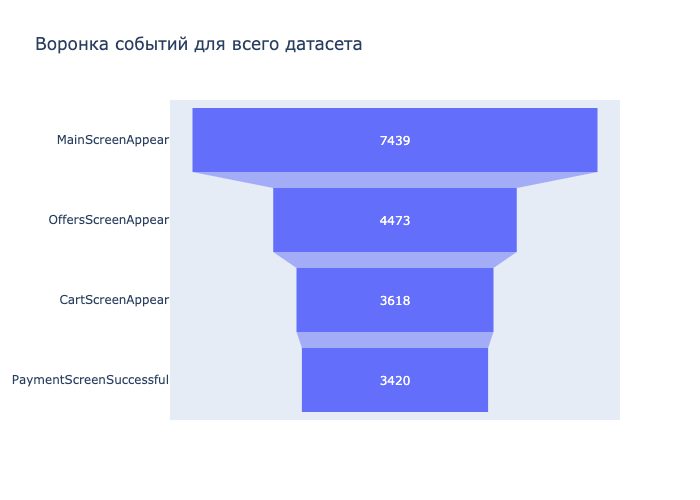

In [35]:
fig = go.Figure(go.Funnel(
    y = funnel_data['event'],
    x = funnel_data['users']
))

fig.update_layout(title_text="Воронка событий для всего датасета")

#fig.show()

fig.write_image("/Users/rodion/Documents/plotly_export/funnel.png")
img_bytes = fig.to_image(format="png")
Image(img_bytes)

In [36]:
#пересоберем датафрейм для воронки в ту же переменную так, что можно было построить одну воронку для трех групп
funnel_data = data.groupby(['event', 'test_group'], as_index=False).agg({'timestamp': 'count', 'id': 'nunique'}
                                         ).sort_values(by='timestamp', ascending=False)
funnel_data.columns=['event', 'test_group', 'event_quantity', 'users']
funnel_data = funnel_data[funnel_data['event'] != 'Tutorial'].reset_index(drop=True)

In [37]:
funnel_data

,event,test_group,event_quantity,users
0,MainScreenAppear,248,41175,2501
1,MainScreenAppear,247,39677,2482
2,MainScreenAppear,246,38249,2456
3,OffersScreenAppear,248,15975,1488
4,CartScreenAppear,248,14404,1191
5,OffersScreenAppear,247,14389,1483
6,OffersScreenAppear,246,14158,1502
7,CartScreenAppear,246,14095,1225
8,CartScreenAppear,247,11707,1202
9,PaymentScreenSuccessful,248,11406,1139


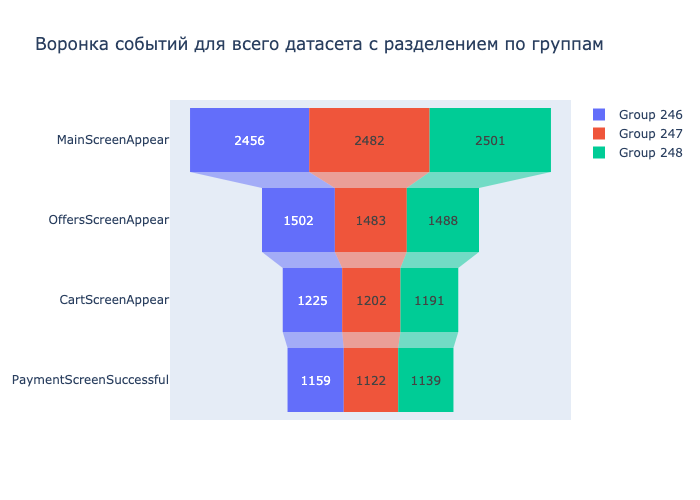

In [74]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name='Group 246',
    y = funnel_data[funnel_data['test_group'] == 246].sort_values(by='users', ascending=False)['event'],
    x = funnel_data[funnel_data['test_group'] == 246].sort_values(by='users', ascending=False)['users']))


fig.add_trace(go.Funnel(
    name='Group 247',
    y = funnel_data[funnel_data['test_group'] == 247].sort_values(by='users', ascending=False)['event'],
    x = funnel_data[funnel_data['test_group'] == 247].sort_values(by='users', ascending=False)['users']))

fig.add_trace(go.Funnel(
    name='Group 248',
    y = funnel_data[funnel_data['test_group'] == 248].sort_values(by='users', ascending=False)['event'],
    x = funnel_data[funnel_data['test_group'] == 248].sort_values(by='users', ascending=False)['users']))

fig.update_layout(title_text="Воронка событий для всего датасета с разделением по группам")
#fig.show()

fig.write_image("/Users/rodion/Documents/plotly_export/funnel2.png")
img_bytes = fig.to_image(format="png")
Image(img_bytes)

Мы визуализировали воронку с учетом разделения количества уникальных пользователей в зависимости от двух факторов: 

- Зарегистрированное событие
- Экспериментальная группа

Визуально, конверсия в следующий шаг происходит без каких-либо заметных отличий:

1. В группах 247 и 248, до последнего шага (успешная оплата) доходят 45.2% и 45.5% соответственно. Отличие в 0.3 процентных пункта
2. В группе 246 до финального шага доходят 47.2% всех пользователей (для всех выборок в среднем, мы имеем 46% пользователей на шаге успешной оплаты)
3. Следует отметить, что устойчивое различие наблюдается при переходе с шага на шаг для всех групп


Поэтому следующим шагом мы должны провести анализ статистической значимости различий между данными в приведенных выборках.



## Анализ результатов эксперимента

### Проверка результатов А/А эксперимента

#### Проверка гипотезы о равенстве долей

In [39]:
#соберем сводную таблицу, в которую запишем количество пользователей в группах на каждом шаге 
events_users = data.loc[data['event'] != 'MainScreenAppear'].pivot_table(index='event', columns='test_group', values='id', aggfunc='nunique'
                ).sort_values(by=246, ascending=False)

events_users['a_group_total'] = events_users[246] + events_users[247]
events_users.set_index(events_users.columns[0])
events_users

test_group,246,247,248,a_group_total
event,,,,
OffersScreenAppear,1502,1483,1488,2985
CartScreenAppear,1225,1202,1191,2427
PaymentScreenSuccessful,1159,1122,1139,2281
Tutorial,24,28,23,52


In [40]:
#получаем сумму по событию mainscreen appear
users_all_groups = data[data['event'] == 'MainScreenAppear'].groupby('event')['id'].nunique().to_frame().sort_values(by='id', ascending=False).reset_index(drop=True)
users_all_groups

,id
0,7439


In [41]:
events_users

test_group,246,247,248,a_group_total
event,,,,
OffersScreenAppear,1502,1483,1488,2985
CartScreenAppear,1225,1202,1191,2427
PaymentScreenSuccessful,1159,1122,1139,2281
Tutorial,24,28,23,52


In [42]:
events_users.index

Index(['OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful',
       'Tutorial'],
      dtype='object', name='event')

In [43]:
data.head()

,event,id,timestamp,test_group,date,time,first_main_screen
0,MainScreenAppear,4575588528974610257,2019-07-25 07:43:36,246,2019-07-25,07:43:36,2019-07-25 07:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 14:11:42,246,2019-07-25,14:11:42,2019-07-25 14:11:42
7,MainScreenAppear,5682100281902512875,2019-07-25 23:14:37,246,2019-07-25,23:14:37,2019-07-25 23:14:37
8,MainScreenAppear,1850981295691852772,2019-07-25 23:31:42,247,2019-07-25,23:31:42,2019-07-25 23:31:42
9,MainScreenAppear,5407636962369102641,2019-07-26 06:35:12,246,2019-07-26,06:35:12,2019-07-26 06:35:12


In [44]:
#для упрощения получения доли по событию относительно количества пользователей на первом шаге, 
users = data.groupby('test_group')['id'].nunique().to_frame().reset_index()
users.loc[3] = ['a_group_total', 4938]
users = users.set_index(users.columns[0])
users

,id
test_group,
246,2456
247,2482
248,2501
a_group_total,4938


In [45]:
users.loc[[246, 247]]['id']

test_group
246    2456
247    2482
Name: id, dtype: int64

In [46]:
#функция будет принимать значения для групп, доли по событиям внутри которых по хотим посчитать 

def group_z_test(group1, group2):
    for event in events_users.index: #для каждого события в индексе датафрейма с событиями и количесвом юзеров мы начинаем цикл
        successes = events_users.loc[event] #в эту переменную сохраняем строку с количеством "успехов" по текущему событию
        trials = users.loc[[group1, group2]]['id'] #из датафрейма с "исходным" количеством получим данные по введенным группам
        alpha = 0.05 #критический уровень стат. значимости определим "жестко" в коде на уровне "стандарта"
        p1 = successes[group1]/trials[group1] #считаем пропорцию успехов для 1й группы
        p2 = successes[group2]/trials[group2] #считаем пропорцию успехов для 2й группы
        p_combined = (successes[group1] + successes[group2]) / (trials[group1] + trials[group2]) #комбинированная пропорция
        difference = p1 - p2 #вычисляем разницу пропорций в датасетах
        #вычисляем z-статистику 
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[group1] + 1/trials[group2]))
        #задаем нормальное распределение
        distr = st.norm(0, 1)
        #берем z-статистику по модулю и считаем вероятность получения расхождения
        #далее умножаем на два, так как считаем, что распределение нормальное
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('p-значение: ', p_value)
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница в рамках события', event)
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в рамках события', event) 
        print()

+ Гипотеза Н0: Между долями групп нет статистически значимых различий 
+ Гипотеза Н1: Между долями групп есть статистически значимые различия

In [47]:
#сравним контрольные группы между собой
group_z_test(246, 247)

p-значение:  0.31229728990501116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в рамках события OffersScreenAppear

p-значение:  0.30845292417227954
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в рамках события CartScreenAppear

p-значение:  0.16182144165264623
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в рамках события PaymentScreenSuccessful

p-значение:  0.6034251678927933
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в рамках события Tutorial



In [48]:
#сравним каждую из контрольных групп с тестовой по отдельности
print('РЕЗУЛЬТАТЫ Z-ТЕСТА ДЛЯ КОНТРОЛЬНОЙ ГРУППЫ 246 И ТЕСТОВОЙ ГРУППЫ')
print()
group_z_test(246, 248)

print()

print('РЕЗУЛЬТАТЫ Z-ТЕСТА ДЛЯ КОНТРОЛЬНОЙ ГРУППЫ 247 И ТЕСТОВОЙ ГРУППЫ')
print()
group_z_test(247, 248)

РЕЗУЛЬТАТЫ Z-ТЕСТА ДЛЯ КОНТРОЛЬНОЙ ГРУППЫ 246 И ТЕСТОВОЙ ГРУППЫ

p-значение:  0.2322781835028187
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в рамках события OffersScreenAppear

p-значение:  0.11196308234944707
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в рамках события CartScreenAppear

p-значение:  0.2444744944801056
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в рамках события PaymentScreenSuccessful

p-значение:  0.8343675509271138
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в рамках события Tutorial


РЕЗУЛЬТАТЫ Z-ТЕСТА ДЛЯ КОНТРОЛЬНОЙ ГРУППЫ 247 И ТЕСТОВОЙ ГРУППЫ

p-значение:  0.8550225500028032
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в рамках события OffersScreenAppear

p-значение:  0.5682538570608564
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в рамках события CartScreenApp

In [49]:
#сравним объединенную контрольную группу  с тестовой
group_z_test('a_group_total', 248)

p-значение:  0.4275709941566088
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в рамках события OffersScreenAppear

p-значение:  0.21274888724893737
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в рамках события CartScreenAppear

p-значение:  0.5945632014562305
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в рамках события PaymentScreenSuccessful

p-значение:  0.5863182242928775
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в рамках события Tutorial



In [50]:
#тут доработанная функция z-теста
#полагаю, что trials, выступая фиксированным значением, позволяет нам упростить некоторые вычисления 
def z_test_main_screen(group1, group2):
    total_main_screen = users_all_groups.loc[0, 'id']
    successes = events_users.loc['MainScreenAppear']
    trials = total_main_screen
    alpha = 0.05
    p1 = successes[group1]/trials
    p2 = successes[group2]/trials
    p_combined = (successes[group1] + successes[group2]) / trials
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница в рамках события MainScreenAppear для групп', group1, 'и', group2)
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в рамках события MainScreenAppearдля групп', group1, 'и', group2) 
    print()
    
#соберем сводную таблицу, в которую запишем количество пользователей в группах на каждом шаге 
events_users = data.loc[data['event'] == 'MainScreenAppear'].pivot_table(index='event', columns='test_group', values='id', aggfunc='nunique'
                ).sort_values(by=246, ascending=False)

events_users['a_group_total'] = events_users[246] + events_users[247]
events_users.set_index(events_users.columns[0])
events_users

#сравним контрольные группы между собой и каждую группу с тестовой группой
z_test_main_screen(246, 247)
z_test_main_screen(246, 248)
z_test_main_screen(247, 248)

p-значение:  0.5233995066511095
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в рамках события MainScreenAppearдля групп 246 и 247

p-значение:  0.26850131718484627
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в рамках события MainScreenAppearдля групп 246 и 248

p-значение:  0.6394720639886717
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными в рамках события MainScreenAppearдля групп 247 и 248



Мы наблюдаем отсутствие статистически значимых отличий между долями групп в воронке конверсии. Таким образом, мы можем предположит, что изменения, проверяемые в ходе теста, не оказали влияние на конверсию.

#### Проверка по количеству событий в группах

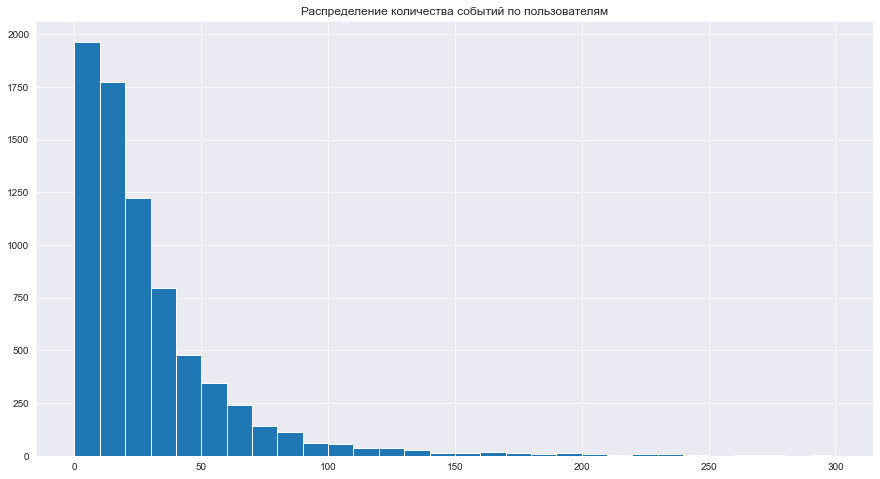

In [51]:
#построим гистограмму, посчитав количество событий, совершенных каждым пользователем
data.groupby('id', as_index=False).agg({'timestamp': 'count'})['timestamp'].hist(bins=30, range=(0, 300), figsize=(15, 8))
plt.title('Распределение количества событий по пользователям')
plt.show()

Группы 246 и 247 в рамках  эксперимента выступали контрольными. Для начала проверим, нет ли в них статистически значимых различий.

Так как: 

1. Данные количественные
2. Даже визуальное распределение исходных данных крайне далеко от нормального
3. Группы независимы друг от друга (в идеале, что соответствует идее А/В теста) 
4. Мы сравниваем 2 группы

Мы выберем критерий Манна-Уитни

In [52]:
#сформируем списки числовых значений, каждая цифра в которых будет равна сумме событий по уникальному ID посетителя
a = data[data['test_group'] == 246].groupby('id', as_index=False).agg({'timestamp': 'count'})['timestamp']
b = data[data['test_group'] == 247].groupby('id', as_index=False).agg({'timestamp': 'count'})['timestamp']

**Гипотезы**

- Н0: Группы 246 и 247 не имеют статистически значимых отличий между собой 
- Н1: Группы 246 и 247 имеют статистически значимые отличия

In [53]:
#проводим тест Манна-Уитни и получаем p-значение на выходе
stat, p = st.mannwhitneyu(a, b)

#задаем критический уровень статистической значимости 
alpha = 0.05

print('Такое же или большее отличие между группами может быть получено случайно с вероятностью {:.2f}%'.format(p*100))

if p < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Такое же или большее отличие между группами может быть получено случайно с вероятностью 48.20%
Не получилось отвергнуть нулевую гипотезу


Таким образом, мы можем утверждать, что группы контрольные группы 246 и 247 не имеют между собой статистически значимых отличий, а значит любая из них может быть использована для А/В тест с экспериментальной группой.

### Анализ событий

In [54]:
#так как мы убедились, что контрольные группы не имеют между собой статистически значимых различий, то мы 
#объединим их в 1 контрольную группу
a_group = data[data['test_group'] < 248]

#формируем второй датафрейм, в который запишем данные тестовой группы
test_group = data[data['test_group'] == 248]

In [55]:
#вызовем повторно сводную таблицу с данными о событиях
events_users

test_group,246,247,248,a_group_total
event,,,,
MainScreenAppear,2456,2482,2501,4938


In [56]:
g246 = data[data['test_group'] == 246]
g247 = data[data['test_group'] == 247]

In [57]:
#количество уникальных пользователей по группам/событиям
data.pivot_table(index='event', columns='test_group', values='id', aggfunc='nunique'
                ).reset_index().sort_values(by=246, ascending=False)

test_group,event,246,247,248
1,MainScreenAppear,2456,2482,2501
2,OffersScreenAppear,1502,1483,1488
0,CartScreenAppear,1225,1202,1191
3,PaymentScreenSuccessful,1159,1122,1139
4,Tutorial,24,28,23


In [58]:
#по аналогии с вышеприведенным анализом двух контрольных выборок при помощи непараметрического критерия, 
#мы препарируем кажду группу и сделаем отдельный тест для каждого события
def groups_checker(group1, group2):
    events = list(group1['event'].unique())
    for event in events:
        a = group1[group1['event'] == event].groupby('id', as_index=False).agg({'timestamp': 'count'})['timestamp']
        b = group2[group2['event'] == event].groupby('id', as_index=False).agg({'timestamp': 'count'})['timestamp']
        stat, p = st.mannwhitneyu(a, b)
        alpha = 0.05
        if p < alpha:
            print('Отвергаем гипотезу об отсутствии различий между группами по событию', event)
        else:
            print('Не получилось отвергнуть нулевую гипотезу об отсутствии различий между группами по событию', event)
        print('Такое же или большее отличие между группами может быть получено случайно с вероятностью {:.2f}%'.format(p*100))
        print()

In [59]:
#запускаем функцию в работу и получаем результат
groups_checker(g246, g247)

Не получилось отвергнуть нулевую гипотезу об отсутствии различий между группами по событию MainScreenAppear
Такое же или большее отличие между группами может быть получено случайно с вероятностью 30.63%

Не получилось отвергнуть нулевую гипотезу об отсутствии различий между группами по событию OffersScreenAppear
Такое же или большее отличие между группами может быть получено случайно с вероятностью 37.08%

Не получилось отвергнуть нулевую гипотезу об отсутствии различий между группами по событию CartScreenAppear
Такое же или большее отличие между группами может быть получено случайно с вероятностью 19.05%

Отвергаем гипотезу об отсутствии различий между группами по событию Tutorial
Такое же или большее отличие между группами может быть получено случайно с вероятностью 3.99%

Не получилось отвергнуть нулевую гипотезу об отсутствии различий между группами по событию PaymentScreenSuccessful
Такое же или большее отличие между группами может быть получено случайно с вероятностью 18.35%



Мы видим, что статистически значимых различий в количестве различных событий на пользователя в обеих контрольных группах нет - это значит, что конверсия с предыдущего на последующий шаг воронки в этих группах сопоставима и мы можем смело объединять их в 1 контрольную группу для проверки, есть ли значимые различия между контрольными группами и тестовой группой. 

Следует обратить внимание на различие по событию `Tutorial`. Однако ранее мы установили, что это событие, судя по контексту и количество его появлений в выборках, принадлежит к ветвлению процесса и является факультативным. Другими словами, для проверки гипотез относительно коммерческой эффективности нововведений имеет смысл использовать выборки с исключенным этим событием. 

Теперь, в соответствии с поставленной задачей, мы проведем проверки тестовой группы с каждой из контрольных групп по отдельности в разрезе событий. 

In [60]:
#пересоберем все группы без события Tutorial
a_group = data[(data['test_group'] < 248) & (data['event'] != 'Tutorial')]
test_group = data[(data['test_group'] == 248) & (data['event'] != 'Tutorial')]
g246 = data[(data['test_group'] == 246) & (data['event'] != 'Tutorial')]
g247 = data[(data['test_group'] == 247) & (data['event'] != 'Tutorial')]

In [61]:
groups_checker(g246, test_group)

Не получилось отвергнуть нулевую гипотезу об отсутствии различий между группами по событию MainScreenAppear
Такое же или большее отличие между группами может быть получено случайно с вероятностью 5.18%

Не получилось отвергнуть нулевую гипотезу об отсутствии различий между группами по событию OffersScreenAppear
Такое же или большее отличие между группами может быть получено случайно с вероятностью 47.25%

Не получилось отвергнуть нулевую гипотезу об отсутствии различий между группами по событию CartScreenAppear
Такое же или большее отличие между группами может быть получено случайно с вероятностью 5.29%

Не получилось отвергнуть нулевую гипотезу об отсутствии различий между группами по событию PaymentScreenSuccessful
Такое же или большее отличие между группами может быть получено случайно с вероятностью 25.76%



In [62]:
groups_checker(g247, test_group)

Не получилось отвергнуть нулевую гипотезу об отсутствии различий между группами по событию MainScreenAppear
Такое же или большее отличие между группами может быть получено случайно с вероятностью 13.42%

Отвергаем гипотезу об отсутствии различий между группами по событию CartScreenAppear
Такое же или большее отличие между группами может быть получено случайно с вероятностью 0.56%

Не получилось отвергнуть нулевую гипотезу об отсутствии различий между группами по событию OffersScreenAppear
Такое же или большее отличие между группами может быть получено случайно с вероятностью 39.78%

Не получилось отвергнуть нулевую гипотезу об отсутствии различий между группами по событию PaymentScreenSuccessful
Такое же или большее отличие между группами может быть получено случайно с вероятностью 5.95%



In [63]:
groups_checker(a_group, test_group)

Не получилось отвергнуть нулевую гипотезу об отсутствии различий между группами по событию MainScreenAppear
Такое же или большее отличие между группами может быть получено случайно с вероятностью 5.71%

Не получилось отвергнуть нулевую гипотезу об отсутствии различий между группами по событию OffersScreenAppear
Такое же или большее отличие между группами может быть получено случайно с вероятностью 45.67%

Отвергаем гипотезу об отсутствии различий между группами по событию CartScreenAppear
Такое же или большее отличие между группами может быть получено случайно с вероятностью 0.84%

Не получилось отвергнуть нулевую гипотезу об отсутствии различий между группами по событию PaymentScreenSuccessful
Такое же или большее отличие между группами может быть получено случайно с вероятностью 10.22%



**Мы получили любопытные результаты:**

1. Между контрольными группами 246 и 247 нет статистически значимых отличий при движении по "прямой" линии бизнес-процесса
2. Между контрольными группами 246 и 247 **ЕСТЬ** статистически значимое отличие в событии `Tutorial`
3. Также мы наблюдаем отсутствие статистически значимых отличий между тестовой группой и контрольной группой 246. Тем не менее, мы наблюдаем вероятность наличия различий в количестве событий на пользователя, близкую к критическому уровню статистической значимости (в нашем случае 5%):
    - Событие `MainScreenAppear` с вероятностью 5.18%
    - Событие `CartScreenAppear` с вероятностью 5.29%
4. Сравнение тестовой группы и контрольной группы 247 говорит нам о том, что по событию `CartScreenAppear` наблюдаются явные статистически значимые отличия (вероятность случайного получения отличий 0.56%). Интересно, что мы продолжим отвергать нулевую гипотезу даже при использовании более строго уровня статистической значимости. 
5. При сравнении тестовой группы с объединенной контрольной группой, мы продолжаем наблюдать статистически значимое отличие в событии `CartScreenAppear` с вероятностью в 0.84%

**Таким образом:**

1. Рекомендуется изучить контрольные выборки и процедуры их формирования/сбора данных, так как в некоторых событиях между ними были зафиксированы отличия
2. Новый шрифт, вероятно, влияет в первую очередь на частоту события `CartScreenAppear`, так как мы наблюдаем статистически значимые отличия
3. Также мы наблюдаем вероятность получения таких же или больших отклонений по событию `MainScreenAppear` в  5.71%, что лежит довольно близко к критическому уровню статистической значимости - рекомендуется обратить внимание

In [64]:
#теперь попробуем понять, в какую сторону наблюдается отклонение
#для этого отберем данные по событию CartScreenAppear из тестовой группы и объединенной контрольной группы

test_cart = test_group[test_group['event'] == 'CartScreenAppear'
                      ].groupby('id', as_index=False).agg({'timestamp': 'count'})
a_group_cart = a_group[(a_group['event'] == 'CartScreenAppear')  & (a_group['test_group'] == 247)
                      ].groupby('id', as_index=False).agg({'timestamp': 'count'})

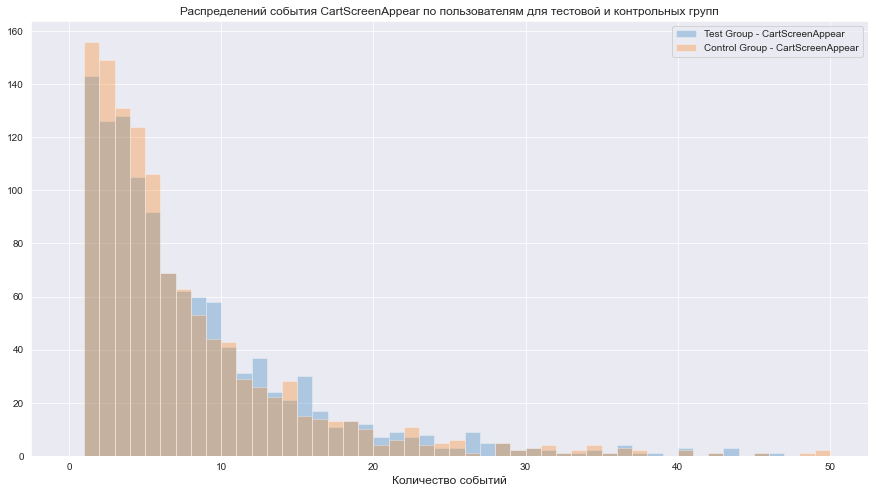

In [65]:
test_cart['timestamp'].hist(bins=50, range=(0, 50), figsize=(15, 8), alpha=0.3, label='Test Group - CartScreenAppear')
a_group_cart['timestamp'].hist(bins=50, range=(0, 50), figsize=(15, 8), alpha=0.3, label='Control Group - CartScreenAppear')
plt.title('Распределений события CartScreenAppear по пользователям для тестовой и контрольных групп')
plt.xlabel('Количество событий', fontsize=12)
plt.legend()
plt.show()

Мы наблюдаем снижение количества событий `CartScreenAppear` для отдельного пользователя в тестовой группе для высокочастотных значений, но начиная с отметки в 8 событий на пользователя напротив наблюдается эпизодический рост. Можем предположить, что изменилось поведение пользователя при переходе в корзину. Необходимо: 

1. Произвести расчеты
2. Посмотреть, что произошло со следующим в цепочке событием

In [66]:
#соберем датафрейм с данными групп 247 и 248, по которым мы нашли статистически значимые отличия для события
#CartScreenAppear
a = data[(data['test_group'] == 247) & (data['event'] == 'CartScreenAppear')].groupby('date', as_index=False).agg({'timestamp': 'count', 'id': 'nunique'})
b = data[(data['test_group'] == 248) & (data['event'] == 'CartScreenAppear')].groupby('date', as_index=False).agg({'timestamp': 'count', 'id': 'nunique'})
a.columns=['date', 'number_of_events_247', 'users_247']
b.columns=['date', 'number_of_events_248', 'users_248']
graph_data = a.merge(b, on='date', how='outer').fillna(0).astype('int')
graph_data = graph_data.merge(a, left_on='number_of_events_247', right_on='number_of_events_247', how='left')
graph_data = graph_data[['date_y', 'number_of_events_247', 'users_247_x', 'number_of_events_248', 'users_248']]
graph_data.columns=['date', 'events_247', 'users_247', 'events_248', 'users_248']
graph_data = graph_data.dropna()
graph_data = graph_data[graph_data['events_248'] != 1]

In [67]:
graph_data

,date,events_247,users_247,events_248,users_248
0,2019-07-27,1,1,0,0
1,2019-07-29,1,1,0,0
4,2019-07-31,13,9,19,11
5,2019-08-01,1622,462,1726,469
6,2019-08-02,1838,458,2692,486
7,2019-08-03,2060,471,2194,479
8,2019-08-04,1495,497,2004,482
9,2019-08-05,1382,494,2400,490
10,2019-08-06,1733,483,1887,505
11,2019-08-07,1562,465,1473,461


Мы наблюдаем, что примерно со 2 августа наблюдается интересная устойчивая тенденция - количество событий `CartScreenAppear` существенно выросло при сопоставимом, а иногда меньшем количестве уникальных идентификаторов пользователей. Другими словами, каждый отдельно взятый пользователь стал чаще переходить в корзину. Посчитаем среднее количество переходов на пользователя для каждой группы.

In [68]:
#считаем среднее количество событий CartScreenAppear на пользователя 
graph_data['avg_events_per_user_247'] = (graph_data['events_247'] / graph_data['users_247']).round(2)
graph_data['avg_events_per_user_248'] = (graph_data['events_248'] / graph_data['users_248']).fillna(0).round(2)

#считаем соотношение среднего количества визитов на пользователя в тестовой группе к контрольной группе
graph_data['avg_visits_coefficient'] = ((graph_data['avg_events_per_user_248'] / graph_data['avg_events_per_user_247'])-1).round(2)

#посчитаем также соотношение пользователей
graph_data['unique_users_coeff'] = ((graph_data['users_248'] / graph_data['users_247']) - 1).round(2)

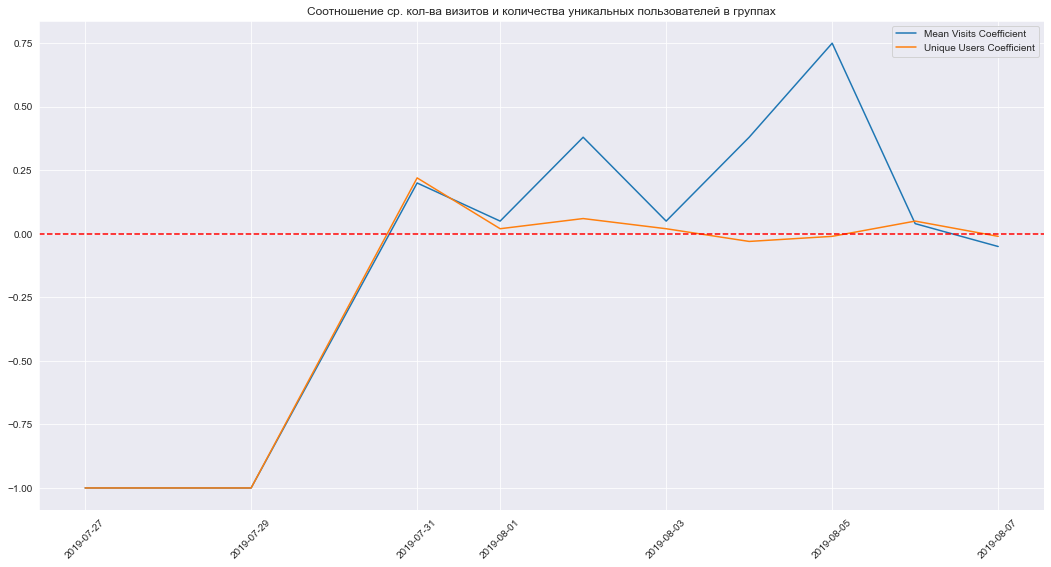

In [69]:
sns.set_style('darkgrid')

plt.figure(figsize=(18, 9))
plt.plot(graph_data['date'], graph_data['avg_visits_coefficient'], label='Mean Visits Coefficient')
plt.plot(graph_data['date'], graph_data['unique_users_coeff'], label='Unique Users Coefficient')
plt.xticks(rotation=45)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Соотношение ср. кол-ва визитов и количества уникальных пользователей в группах', fontsize=12)
plt.legend()

plt.show()

**На наблюдаем следующее:**

1. "Стартовые колебания" эксперимента прекратились примерно к 1 августа
2. На графика три пиковых значения: 31 июля, 2 августа и 5 августа. В эти дни соотношение среднего количества зарегистрированных событий на 1 пользователя в тестовой группе превышало аналогичное значение в контрольной группе на 50-75%
3. С 1 августа, несмотря на колебания среднего числа переходов в корзину, количество уникальных пользователей в группах варьировалась в пределах -4/+6 процентов

Предположительно, по какой-то причине у пользователей в связи с изменением шрифта возникла потребность чаще переходить в корзину. 

In [70]:
#соберем датафрейм с данными групп 247 и 248, по которым мы нашли статистически значимые отличия для события
#CartScreenAppear
a = data[(data['test_group'] == 247) & (data['event'] == 'PaymentScreenSuccessful')].groupby('date', as_index=False).agg({'timestamp': 'count', 'id': 'nunique'})
b = data[(data['test_group'] == 248) & (data['event'] == 'PaymentScreenSuccessful')].groupby('date', as_index=False).agg({'timestamp': 'count', 'id': 'nunique'})
a.columns=['date', 'number_of_events_247', 'users_247']
b.columns=['date', 'number_of_events_248', 'users_248']
graph_data = a.merge(b, on='date', how='outer').fillna(0).astype('int')
graph_data = graph_data.merge(a, left_on='number_of_events_247', right_on='number_of_events_247', how='left')
graph_data = graph_data[['date_y', 'number_of_events_247', 'users_247_x', 'number_of_events_248', 'users_248']]
graph_data.columns=['date', 'events_247', 'users_247', 'events_248', 'users_248']
graph_data = graph_data.dropna()
graph_data = graph_data[graph_data['events_248'] != 1]

In [71]:
graph_data

,date,events_247,users_247,events_248,users_248
0,2019-07-31,2,1,3,3
1,2019-08-01,1246,406,1245,435
2,2019-08-02,1491,424,2231,441
3,2019-08-03,1694,433,1723,449
4,2019-08-04,1187,463,1589,451
5,2019-08-05,1076,459,1942,462
6,2019-08-06,1390,456,1483,485
7,2019-08-07,1303,448,1188,432


In [72]:
#считаем среднее количество событий CartScreenAppear на пользователя 
graph_data['avg_events_per_user_247'] = (graph_data['events_247'] / graph_data['users_247']).round(2)
graph_data['avg_events_per_user_248'] = (graph_data['events_248'] / graph_data['users_248']).fillna(0).round(2)

#считаем соотношение среднего количества визитов на пользователя в тестовой группе к контрольной группе
graph_data['avg_visits_coefficient'] = ((graph_data['avg_events_per_user_248'] / graph_data['avg_events_per_user_247'])-1).round(2)

#посчитаем также соотношение пользователей
graph_data['unique_users_coeff'] = ((graph_data['users_248'] / graph_data['users_247']) - 1).round(2)

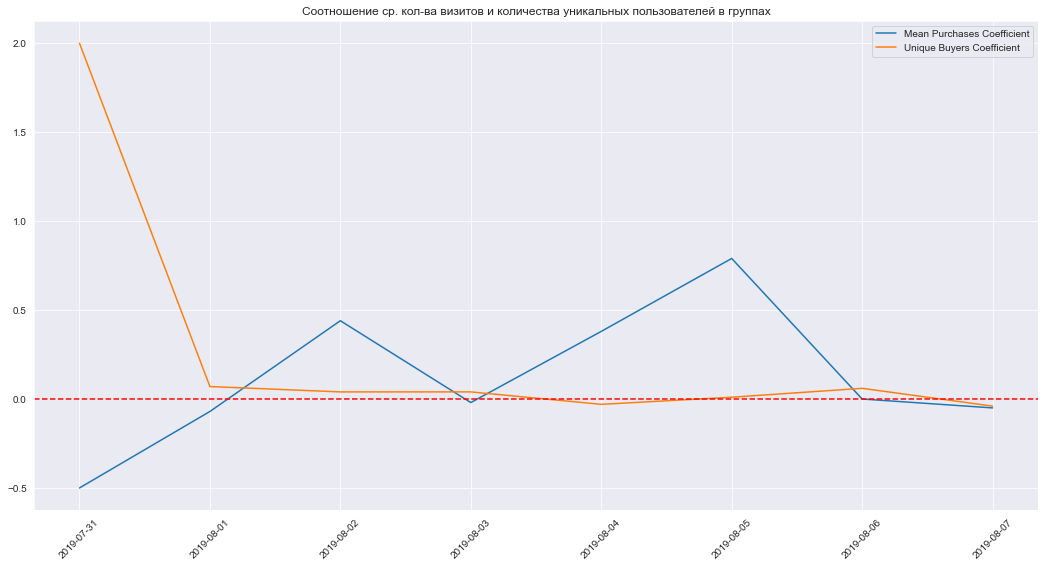

In [73]:
sns.set_style('darkgrid')

plt.figure(figsize=(18, 9))
plt.plot(graph_data['date'], graph_data['avg_visits_coefficient'], label='Mean Purchases Coefficient')
plt.plot(graph_data['date'], graph_data['unique_users_coeff'], label='Unique Buyers Coefficient')
plt.xticks(rotation=45)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Соотношение ср. кол-ва визитов и количества уникальных пользователей в группах', fontsize=12)
plt.legend()

plt.show()

**Мы наблюдаем:**

1. Сохранились пики 31 июля, 2 августа и 5 августа - в эти дни помимо большего числа переходов в корзину также наблюдалось большее количество покупок
2. По-прежнему количество уникальных покупателей не сильно варьируется в группах -3/+7 процентов
3. Для 247й контрольной группы вероятность получения таких или больших различий по количеству событий на пользователя составляет 7.76%, что довольно близко к заданному критическому уровню статистической значимости (при менее строгом уровне, мы бы отвергли гипотезу о равенстве выборок). С другой стороны, для общей контрольной группы и тестовой группы это значение уже составляет 12.62%

# Вывод

**Вывод:**

1. Проверка долей показала отсутствие статистически различий между пропорциями по событиями воронки конверсии. Таким образом, мы можем утверждать, что нововведение не влияет на результаты конверсии по результатам теста
1. Обработана выборка по трем группам (две контрольные и одна тестовая) за период 25.07.2019-07.08.2019
2. В процессе предобработки:
    - Удалено 7658 "лишних" событий
    - Датасет сократился на 3.14%
    - Удалено 112 "лишних" пользователей, что составляет 1.48% от исходного исходного количества в датасете
3. Для всей совокупности данных конверсия от исходного количества пользователей составляет: 
    - 60.1% для шага OffersScreenAppear (60.1% от предыдущего шага)
    - 47.6% для шага CartScreenAppear (80.9% от предыдущего шага)
    - 46 для экрана PaymentScreenSuccessful (94.5% от предыдущего шага)
4. Для проверки наличия статистически значимых различий использован непараметрический критерий Манна-Уитни, так как данные явно распределены не нормально (что довольно стандартно для социального явления) коим является процесс покупки
5. Установлено, что при пособытийной проверке в контрольных группах наблюдается статистически значимое отличие по событию Tutorial. Вероятно, для цепочки в целом это событие не является определяющих, но сам факт различий в контрольных группах ставит вопрос к качеству подготовки групп для А/В теста
6. Установлено, что в контрольной и тестовой группе наблюдается статистически значимое отличие для события `CartScreenAppear` - вероятность получения таких же или больших различий для объединенной контрольной группы 0.85%, что позволяет нам отвергнуть нулевую гипотезу даже при использовании более строгого уровня статистической значимости
7. При сравнении тестовой группы с каждой из контрольных групп, в явном виде различие регистрируется только для группы 247, что также вызывает вопросы к качеству подготовки А/В теста (либо процедуре его проведения)
8. Более детальный анализ показывает, что как выросло среднее количество переходов в корзину на 1 пользователя, так и среднее количество покупок на 1 пользователя, но на графиках мы видим 3 явно выраженных пика: 31 июля, 2 августа и 5 августа

**Рекомендации**

1. Проверить качество подготовки тест и процедуру его проведения на предмет возможных ошибок
2. Изучить поведение пользователя в процессе совершения покупки - рост числа переходов в корзину связан с более удобной организацией интерфейса предложений, либо изменный шрифт заставляет пользователей делать лишние клики/тапы
3. Изучить средний чек пользователей в разных группах на предмет наличия статистически значимых отличий в нем (возможно, имеет смысл сделать изучение с погружением до уровня товарных категорий)
4. Если с изначальной организацией теста все в порядке, стоит продлить тестирование для исключения фактора "смещения" фокуса за счет пиковых значений, видимых на графиках - по представленным данным нельзя ясно утверждать, какой событие является причиной, а какое следствием: либо шрифт повлиял на поведение, либо что-то произошло с поведением и мы увидели отличия, будто дело в шрифте